In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the classes and create the data loader

In [3]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in letters]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Create the model

In [6]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = table_dnn.LabelGuidedTabularNet(
    len(classes), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/letters_continuous_allletters_labelguided"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

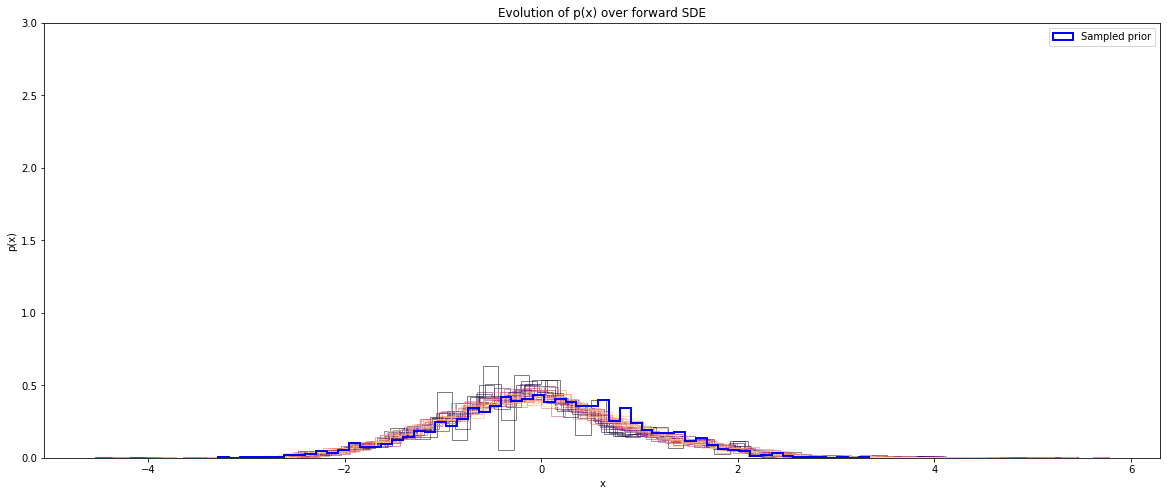

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_to_class_index": class_to_class_index_tensor,
        "num_epochs": 100,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
INFO - train - Started run with ID "1"
Loss: 11.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.03it/s]


Epoch 1 average Loss: 12.15


Loss: 8.23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.05it/s]


Epoch 2 average Loss: 10.23


Loss: 9.03: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.51it/s]


Epoch 3 average Loss: 9.78


Loss: 9.37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 41.13it/s]


Epoch 4 average Loss: 9.43


Loss: 9.53: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.82it/s]


Epoch 5 average Loss: 9.30


Loss: 8.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.35it/s]


Epoch 6 average Loss: 9.05


Loss: 10.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 54.68it/s]


Epoch 7 average Loss: 8.97


Loss: 8.99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 45.52it/s]


Epoch 8 average Loss: 8.84


Loss: 9.43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.26it/s]


Epoch 9 average Loss: 8.75


Loss: 6.87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.63it/s]


Epoch 10 average Loss: 8.61


Loss: 8.88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 75.89it/s]


Epoch 11 average Loss: 8.66


Loss: 9.37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.61it/s]


Epoch 12 average Loss: 8.54


Loss: 7.54: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.75it/s]


Epoch 13 average Loss: 8.45


Loss: 8.45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.20it/s]


Epoch 14 average Loss: 8.47


Loss: 8.56: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.34it/s]


Epoch 15 average Loss: 8.43


Loss: 8.34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.60it/s]


Epoch 16 average Loss: 8.30


Loss: 9.32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.07it/s]


Epoch 17 average Loss: 8.31


Loss: 8.66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.03it/s]


Epoch 18 average Loss: 8.34


Loss: 7.81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.15it/s]


Epoch 19 average Loss: 8.27


Loss: 9.72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.63it/s]


Epoch 20 average Loss: 8.22


Loss: 7.35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 86.90it/s]


Epoch 21 average Loss: 8.20


Loss: 8.21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.75it/s]


Epoch 22 average Loss: 8.15


Loss: 7.55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.80it/s]


Epoch 23 average Loss: 8.14


Loss: 6.13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.78it/s]


Epoch 24 average Loss: 8.04


Loss: 6.71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.14it/s]


Epoch 25 average Loss: 8.07


Loss: 8.05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.77it/s]


Epoch 26 average Loss: 8.09


Loss: 7.88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.76it/s]


Epoch 27 average Loss: 8.04


Loss: 7.89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.75it/s]


Epoch 28 average Loss: 8.02


Loss: 8.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.93it/s]


Epoch 29 average Loss: 7.90


Loss: 7.47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.43it/s]


Epoch 30 average Loss: 8.00


Loss: 7.51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.18it/s]


Epoch 31 average Loss: 7.92


Loss: 6.95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 67.53it/s]


Epoch 32 average Loss: 7.83


Loss: 7.39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 84.62it/s]


Epoch 33 average Loss: 7.88


Loss: 7.50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.58it/s]


Epoch 34 average Loss: 7.83


Loss: 7.64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.33it/s]


Epoch 35 average Loss: 7.87


Loss: 6.67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.58it/s]


Epoch 36 average Loss: 7.82


Loss: 9.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 75.25it/s]


Epoch 37 average Loss: 7.82


Loss: 8.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.56it/s]


Epoch 38 average Loss: 7.82


Loss: 8.25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 71.25it/s]


Epoch 39 average Loss: 7.86


Loss: 8.48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.83it/s]


Epoch 40 average Loss: 7.82


Loss: 9.03: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.47it/s]


Epoch 41 average Loss: 7.76


Loss: 6.83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 74.37it/s]


Epoch 42 average Loss: 7.74


Loss: 7.47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.76it/s]


Epoch 43 average Loss: 7.74


Loss: 7.86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 88.88it/s]


Epoch 44 average Loss: 7.79


Loss: 9.26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 90.31it/s]


Epoch 45 average Loss: 7.72


Loss: 6.94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.61it/s]


Epoch 46 average Loss: 7.69


Loss: 6.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 75.02it/s]


Epoch 47 average Loss: 7.73


Loss: 7.34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.12it/s]


Epoch 48 average Loss: 7.66


Loss: 6.94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.48it/s]


Epoch 49 average Loss: 7.70


Loss: 7.97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 88.26it/s]


Epoch 50 average Loss: 7.74


Loss: 8.13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.81it/s]


Epoch 51 average Loss: 7.66


Loss: 6.93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.30it/s]


Epoch 52 average Loss: 7.71


Loss: 7.95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 89.78it/s]


Epoch 53 average Loss: 7.64


Loss: 6.35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 82.48it/s]


Epoch 54 average Loss: 7.65


Loss: 8.30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.75it/s]


Epoch 55 average Loss: 7.70


Loss: 7.17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.28it/s]


Epoch 56 average Loss: 7.56


Loss: 6.12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.95it/s]


Epoch 57 average Loss: 7.62


Loss: 7.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 92.01it/s]


Epoch 58 average Loss: 7.65


Loss: 6.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.01it/s]


Epoch 59 average Loss: 7.59


Loss: 7.49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.43it/s]


Epoch 60 average Loss: 7.63


Loss: 7.72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.83it/s]


Epoch 61 average Loss: 7.58


Loss: 7.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.60it/s]


Epoch 62 average Loss: 7.57


Loss: 8.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.79it/s]


Epoch 63 average Loss: 7.62


Loss: 7.17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.76it/s]


Epoch 64 average Loss: 7.55


Loss: 8.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.60it/s]


Epoch 65 average Loss: 7.62


Loss: 6.74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.24it/s]


Epoch 66 average Loss: 7.58


Loss: 8.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.48it/s]


Epoch 67 average Loss: 7.55


Loss: 5.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.28it/s]


Epoch 68 average Loss: 7.58


Loss: 8.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 102.24it/s]


Epoch 69 average Loss: 7.55


Loss: 7.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.47it/s]


Epoch 70 average Loss: 7.50


Loss: 8.09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 103.94it/s]


Epoch 71 average Loss: 7.51


Loss: 6.88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 99.46it/s]


Epoch 72 average Loss: 7.47


Loss: 9.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.90it/s]


Epoch 73 average Loss: 7.54


Loss: 8.59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 103.97it/s]


Epoch 74 average Loss: 7.47


Loss: 7.85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.47it/s]


Epoch 75 average Loss: 7.46


Loss: 7.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 106.05it/s]


Epoch 76 average Loss: 7.54


Loss: 7.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.54it/s]


Epoch 77 average Loss: 7.47


Loss: 6.75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.53it/s]


Epoch 78 average Loss: 7.49


Loss: 9.25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.67it/s]


Epoch 79 average Loss: 7.50


Loss: 7.81: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 103.19it/s]


Epoch 80 average Loss: 7.50


Loss: 7.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.84it/s]


Epoch 81 average Loss: 7.48


Loss: 7.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.58it/s]


Epoch 82 average Loss: 7.48


Loss: 7.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.57it/s]


Epoch 83 average Loss: 7.49


Loss: 7.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.87it/s]


Epoch 84 average Loss: 7.47


Loss: 7.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.37it/s]


Epoch 85 average Loss: 7.46


Loss: 9.27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.31it/s]


Epoch 86 average Loss: 7.48


Loss: 7.59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.49it/s]


Epoch 87 average Loss: 7.46


Loss: 8.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 106.28it/s]


Epoch 88 average Loss: 7.43


Loss: 7.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 107.29it/s]


Epoch 89 average Loss: 7.39


Loss: 7.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.25it/s]


Epoch 90 average Loss: 7.41


Loss: 8.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.99it/s]


Epoch 91 average Loss: 7.42


Loss: 6.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 105.30it/s]


Epoch 92 average Loss: 7.39


Loss: 7.76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 97.47it/s]


Epoch 93 average Loss: 7.41


Loss: 7.33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.15it/s]


Epoch 94 average Loss: 7.37


Loss: 6.21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 102.28it/s]


Epoch 95 average Loss: 7.39


Loss: 7.28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.27it/s]


Epoch 96 average Loss: 7.36


Loss: 8.85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 102.44it/s]


Epoch 97 average Loss: 7.40


Loss: 7.44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 99.92it/s]


Epoch 98 average Loss: 7.40


Loss: 9.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 104.53it/s]


Epoch 99 average Loss: 7.41


Loss: 7.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 101.85it/s]
INFO - train - Completed after 0:04:49


Epoch 100 average Loss: 7.43
